In [1]:
#3.
import numpy as np
import pandas as pd

# Load dataset
data = pd.read_csv('C:/Users/user/OneDrive/文件/時間序列/Data-GEstock.txt', delimiter="\t", header=None)
returns = data[0].values
returns

array([  4.204,  -0.59 ,  -9.376,   5.45 ,  -0.894,   8.763,   4.712,
         0.971,  -1.953,  -7.062,   6.92 ,  -3.768,  -1.048,   3.114,
         1.737,  10.435,   8.614,   4.674,  16.528,   9.496,  -2.336,
       -11.128,   8.531,   2.781,  -3.944,  -1.35 ,  21.73 ,   2.791,
        -2.321,  -3.341,  -1.32 ,  10.403,  -0.752,   0.152,  19.362,
        10.984,  14.865,  -4.578,  -2.684,   2.49 ,   9.102,  20.101,
        15.051,   4.658,  -9.614, -35.18 , -15.647,  12.83 ,  17.477,
         4.879,  10.91 ,   2.484,  -2.928, -17.457,   0.533,   4.33 ,
       -18.327, -19.138,  -3.793,  -9.681,   0.856,  17.662,  -7.873,
        -9.246, -12.745,  12.801,  -8.388,   1.551, -39.475,  12.516,
        -9.409,  -9.298, -26.136,   2.564, -10.677, -26.881, -43.872,
        10.71 ,  42.286,  35.839, -10.269, -19.177,  -8.48 ,  12.503,
        -0.823, -23.144,   4.879,  44.469,  13.193,   7.987,  -8.135,
        10.705, -21.556, -10.677,  11.935,  -2.02 ,  14.864,  -8.651,
         8.208,  -3.

In [2]:
#3.(a)
# 初始化參數
np.random.seed(42)
iterations = 10000
beta1 = np.random.randn()
beta2 = np.random.randn()
alpha10 = np.random.uniform(0, 1)
alpha11 = np.random.uniform(0, 1)
alpha12 = np.random.uniform(0, 1)
alpha20 = np.random.uniform(0, 1)
alpha21 = np.random.uniform(0, 1)
alpha22 = np.random.uniform(0, 1)
e1 = np.random.beta(1, 1)
e2 = np.random.beta(1, 1)

# 初始化隱狀態變量
T = len(returns)
s = np.random.choice([1, 2], size=T)

# 初始化條件變量
h = np.zeros(T)
h[0] = np.var(returns)

# 定義更新條件變量 h_t 的函數
def update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T):
    h = np.zeros(T)
    h[0] = np.var(returns)
    for t in range(1, T):
        if s[t] == 1:
            h[t] = alpha10 + alpha11 * h[t-1] + alpha12 * returns[t-1]**2
        else:
            h[t] = alpha20 + alpha21 * h[t-1] + alpha22 * returns[t-1]**2
        if h[t] <= 0:  # 避免 h[t] 為負值
            h[t] = 1e-6
    return h

# 定義 Gibbs 取樣過程
def gibbs_sampling(returns, iterations):
    # 初始化參數
    beta1 = np.random.randn()
    beta2 = np.random.randn()
    alpha10 = np.random.uniform(0, 1)
    alpha11 = np.random.uniform(0, 1)
    alpha12 = np.random.uniform(0, 1)
    alpha20 = np.random.uniform(0, 1)
    alpha21 = np.random.uniform(0, 1)
    alpha22 = np.random.uniform(0, 1)
    e1 = np.random.beta(1, 1)
    e2 = np.random.beta(1, 1)

    # 初始化隱狀態變量
    T = len(returns)
    s = np.random.choice([1, 2], size=T)

    # Gibbs 取樣
    for _ in range(iterations):
        # 更新條件變量 h_t
        h = update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T)
        
        # 更新狀態 s_t
        for t in range(T):
            p1 = e1 * np.exp(-0.5 * ((returns[t] - beta1 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            p2 = e2 * np.exp(-0.5 * ((returns[t] - beta2 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            if np.isnan(p1) or np.isnan(p2):  # 檢查是否出現 NaN
                p1, p2 = 0.5, 0.5  # 若出現 NaN，給予預設值
            s[t] = 1 if np.random.rand() < p1 / (p1 + p2) else 2
        
        # 更新 beta1 和 beta2
        if np.sum(s == 1) > 1:  # 確保分母不為零
            n1 = np.sum(s == 1)
            r1_bar = np.sum(returns[s == 1] / np.sqrt(h[s == 1])) / n1
            sigma1_star = 1 / (n1 + 1 / np.var(returns[s == 1]))
            beta1_star = sigma1_star * (n1 * r1_bar + beta1 / np.var(returns[s == 1]))
            beta1 = np.random.normal(beta1_star, np.sqrt(sigma1_star))
        if np.sum(s == 2) > 1:
            n2 = np.sum(s == 2)
            r2_bar = np.sum(returns[s == 2] / np.sqrt(h[s == 2])) / n2
            sigma2_star = 1 / (n2 + 1 / np.var(returns[s == 2]))
            beta2_star = sigma2_star * (n2 * r2_bar + beta2 / np.var(returns[s == 2]))
            beta2 = np.random.normal(beta2_star, np.sqrt(sigma2_star))

        # 更新轉移概率 e1 和 e2
        ell1 = np.sum((s[:-1] == 1) & (s[1:] == 2))
        ell2 = np.sum((s[:-1] == 2) & (s[1:] == 1))
        e1 = np.random.beta(1 + ell1, 1 + np.sum(s == 1) - ell1)
        e2 = np.random.beta(1 + ell2, 1 + np.sum(s == 2) - ell2)

        # 更新 GARCH 參數
        if np.sum(s == 1) > 1:  # 避免分母為0的情況
            alpha10 = np.random.uniform(0, 1)
            alpha11 = np.random.uniform(0, 1)
            alpha12 = np.random.uniform(0, 1)
        if np.sum(s == 2) > 1:
            alpha20 = np.random.uniform(0, 1)
            alpha21 = np.random.uniform(0, 1)
            alpha22 = np.random.uniform(0, 1)

    return beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2

# 執行 Gibbs 取樣
beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2 = gibbs_sampling(returns, iterations)

# 輸出最終估計的參數
print(f'beta1: {beta1}, beta2: {beta2}')
print(f'alpha10: {alpha10}, alpha11: {alpha11}, alpha12: {alpha12}')
print(f'alpha20: {alpha20}, alpha21: {alpha21}, alpha22: {alpha22}')
print(f'e1: {e1}, e2: {e2}')

C:\Users\user\anaconda3\envs\v37\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars


beta1: -0.7248907515735875, beta2: 1.536893749371121
alpha10: 0.40501351406428765, alpha11: 0.8014872062832392, alpha12: 0.8358370822016237
alpha20: 0.7991851823987718, alpha21: 0.030476758994315012, alpha22: 0.290481735418738
e1: 0.4731084839843959, e2: 0.5854130933634795


In [4]:
#3.(b)
# 假设 alpha 的范围为 [0, 1]
def sample_alpha(alpha_current, beta, h, returns, s, state):
    alpha_grid = np.linspace(0.01, 0.99, 100)  # 在 [0.01, 0.99] 区间取 100 个点

    log_likelihoods = []
    for alpha in alpha_grid:
        h_temp = np.copy(h)
        for t in range(1, len(returns)):
            if s[t] == state:
                if state == 1:
                    h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                else:
                    h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                if h_temp[t] <= 0:
                    h_temp[t] = 1e-6  # 确保 h_temp 为正值

        log_likelihood = -0.5 * np.sum(np.log(h_temp[s == state]) + (returns[s == state] - beta[state-1] * np.sqrt(h_temp[s == state]))**2 / h_temp[s == state])
        log_likelihoods.append(log_likelihood)

    log_likelihoods = np.array(log_likelihoods)
    likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))  # 防止溢出
    likelihoods /= np.sum(likelihoods)  # 标准化

    return np.random.choice(alpha_grid, p=likelihoods)

# 定义更新条件变量 h_t 的函数
def update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T):
    h = np.zeros(T)
    h[0] = np.var(returns)
    for t in range(1, T):
        if s[t] == 1:
            h[t] = alpha10 + alpha11 * h[t-1] + alpha12 * returns[t-1]**2
        else:
            h[t] = alpha20 + alpha21 * h[t-1] + alpha22 * returns[t-1]**2
        if h[t] <= 0:  # 避免 h[t] 为负值
            h[t] = 1e-6
    return h

def gibbs_sampling(returns, iterations):
    # 初始化参数
    beta1 = np.random.randn()
    beta2 = np.random.randn()
    alpha10 = np.random.uniform(0.01, 0.1)
    alpha11 = np.random.uniform(0.01, 0.1)
    alpha12 = np.random.uniform(0.01, 0.1)
    alpha20 = np.random.uniform(0.01, 0.1)
    alpha21 = np.random.uniform(0.01, 0.1)
    alpha22 = np.random.uniform(0.01, 0.1)
    e1 = np.random.beta(1, 1)
    e2 = np.random.beta(1, 1)

    # 初始化隐状态变量
    T = len(returns)
    s = np.random.choice([1, 2], size=T)

    # Gibbs 取样
    for _ in range(iterations):
        # 更新条件变量 h_t
        h = update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T)
        
        # 更新状态 s_t
        for t in range(T):
            p1 = e1 * np.exp(-0.5 * ((returns[t] - beta1 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            p2 = e2 * np.exp(-0.5 * ((returns[t] - beta2 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            if np.isnan(p1) or np.isnan(p2):  # 检查是否出现 NaN
                p1, p2 = 0.5, 0.5  # 若出现 NaN，给予默认值
            s[t] = 1 if np.random.rand() < p1 / (p1 + p2) else 2
        
        # 更新 beta1 和 beta2
        if np.sum(s == 1) > 1:  # 确保分母不为零
            n1 = np.sum(s == 1)
            r1_bar = np.sum(returns[s == 1] / np.sqrt(h[s == 1])) / n1
            sigma1_star = 1 / (n1 + 1 / np.var(returns[s == 1]))
            beta1_star = sigma1_star * (n1 * r1_bar + beta1 / np.var(returns[s == 1]))
            beta1 = np.random.normal(beta1_star, np.sqrt(sigma1_star))
        if np.sum(s == 2) > 1:
            n2 = np.sum(s == 2)
            r2_bar = np.sum(returns[s == 2] / np.sqrt(h[s == 2])) / n2
            sigma2_star = 1 / (n2 + 1 / np.var(returns[s == 2]))
            beta2_star = sigma2_star * (n2 * r2_bar + beta2 / np.var(returns[s == 2]))
            beta2 = np.random.normal(beta2_star, np.sqrt(sigma2_star))

        # 更新转移概率 e1 和 e2
        ell1 = np.sum((s[:-1] == 1) & (s[1:] == 2))
        ell2 = np.sum((s[:-1] == 2) & (s[1:] == 1))
        e1 = np.random.beta(1 + ell1, 1 + np.sum(s == 1) - ell1)
        e2 = np.random.beta(1 + ell2, 1 + np.sum(s == 2) - ell2)

        # 使用 Griddy Gibbs 方法更新 GARCH 参数
        if np.sum(s == 1) > 1:  # 避免分母为0的情况
            alpha10 = sample_alpha([alpha10, alpha11], [beta1, beta2], h, returns, s, 1)
            alpha11 = sample_alpha([alpha10, alpha12], [beta1, beta2], h, returns, s, 1)
            alpha12 = sample_alpha([alpha11, alpha12], [beta1, beta2], h, returns, s, 1)
        if np.sum(s == 2) > 1:
            alpha20 = sample_alpha([alpha20, alpha21], [beta1, beta2], h, returns, s, 2)
            alpha21 = sample_alpha([alpha20, alpha22], [beta1, beta2], h, returns, s, 2)
            alpha22 = sample_alpha([alpha21, alpha22], [beta1, beta2], h, returns, s, 2)

    return beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2

# 执行 Gibbs 取样
beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2 = gibbs_sampling(returns, iterations)

# 输出最终估计的参数
print(f'beta1: {beta1}, beta2: {beta2}')
print(f'alpha10: {alpha10}, alpha11: {alpha11}, alpha12: {alpha12}')
print(f'alpha20: {alpha20}, alpha21: {alpha21}, alpha22: {alpha22}')
print(f'e1: {e1}, e2: {e2}')

C:\Users\user\anaconda3\envs\v37\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [5]:

# 假设 alpha 的范围为 [0, 1]
def sample_alpha(alpha_current, beta, h, returns, s, state, index):
    alpha_grid = np.linspace(0.01, 0.99, 50)  # 在 [0.01, 0.99] 区间取 50 个点

    log_likelihoods = []
    for alpha in alpha_grid:
        h_temp = np.copy(h)
        for t in range(1, len(returns)):
            if s[t] == state:
                if state == 1:
                    if index == 2:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                    elif index == 1:
                        h_temp[t] = alpha + alpha_current[1] * h_temp[t-1] + alpha_current[2] * returns[t-1]**2
                    elif index == 3:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                else:
                    if index == 2:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                    elif index == 1:
                        h_temp[t] = alpha + alpha_current[1] * h_temp[t-1] + alpha_current[2] * returns[t-1]**2
                    elif index == 3:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                if h_temp[t] <= 0:
                    h_temp[t] = 1e-6  # 确保 h_temp 为正值

        log_likelihood = -0.5 * np.sum(np.log(h_temp[s == state]) + (returns[s == state] - beta[state-1] * np.sqrt(h_temp[s == state]))**2 / h_temp[s == state])
        log_likelihoods.append(log_likelihood)

    log_likelihoods = np.array(log_likelihoods)
    likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))  # 防止溢出
    likelihoods /= np.sum(likelihoods)  # 标准化

    return np.random.choice(alpha_grid, p=likelihoods)

# 定义更新条件变量 h_t 的函数
def update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T):
    h = np.zeros(T)
    h[0] = np.var(returns)
    for t in range(1, T):
        if s[t] == 1:
            h[t] = alpha10 + alpha11 * h[t-1] + alpha12 * returns[t-1]**2
        else:
            h[t] = alpha20 + alpha21 * h[t-1] + alpha22 * returns[t-1]**2
        if h[t] <= 0:  # 避免 h[t] 为负值
            h[t] = 1e-6
    return h

def gibbs_sampling(returns, iterations):
    # 初始化参数
    beta1 = np.random.randn()
    beta2 = np.random.randn()
    alpha10 = np.random.uniform(0.01, 0.1)
    alpha11 = np.random.uniform(0.01, 0.1)
    alpha12 = np.random.uniform(0.01, 0.1)
    alpha20 = np.random.uniform(0.01, 0.1)
    alpha21 = np.random.uniform(0.01, 0.1)
    alpha22 = np.random.uniform(0.01, 0.1)
    e1 = np.random.beta(1, 1)
    e2 = np.random.beta(1, 1)

    # 初始化隐状态变量
    T = len(returns)
    s = np.random.choice([1, 2], size=T)

    # Gibbs 取样
    for _ in range(iterations):
        # 更新条件变量 h_t
        h = update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T)
        
        # 更新状态 s_t
        for t in range(T):
            p1 = e1 * np.exp(-0.5 * ((returns[t] - beta1 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            p2 = e2 * np.exp(-0.5 * ((returns[t] - beta2 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            if np.isnan(p1) or np.isnan(p2):  # 检查是否出现 NaN
                p1, p2 = 0.5, 0.5  # 若出现 NaN，给予默认值
            s[t] = 1 if np.random.rand() < p1 / (p1 + p2) else 2
        
        # 更新 beta1 和 beta2
        if np.sum(s == 1) > 1:  # 确保分母不为零
            n1 = np.sum(s == 1)
            r1_bar = np.sum(returns[s == 1] / np.sqrt(h[s == 1])) / n1
            sigma1_star = 1 / (n1 + 1 / np.var(returns[s == 1]))
            beta1_star = sigma1_star * (n1 * r1_bar + beta1 / np.var(returns[s == 1]))
            beta1 = np.random.normal(beta1_star, np.sqrt(sigma1_star))
        if np.sum(s == 2) > 1:
            n2 = np.sum(s == 2)
            r2_bar = np.sum(returns[s == 2] / np.sqrt(h[s == 2])) / n2
            sigma2_star = 1 / (n2 + 1 / np.var(returns[s == 2]))
            beta2_star = sigma2_star * (n2 * r2_bar + beta2 / np.var(returns[s == 2]))
            beta2 = np.random.normal(beta2_star, np.sqrt(sigma2_star))

        # 更新转移概率 e1 和 e2
        ell1 = np.sum((s[:-1] == 1) & (s[1:] == 2))
        ell2 = np.sum((s[:-1] == 2) & (s[1:] == 1))
        e1 = np.random.beta(1 + ell1, 1 + np.sum(s == 1) - ell1)
        e2 = np.random.beta(1 + ell2, 1 + np.sum(s == 2) - ell2)

        # 使用 Griddy Gibbs 方法更新 GARCH 参数
        if np.sum(s == 1) > 1:  # 避免分母为0的情况
            alpha10 = sample_alpha([alpha10, alpha11, alpha12], [beta1, beta2], h, returns, s, 1, 1)
            alpha11 = sample_alpha([alpha10, alpha11, alpha12], [beta1, beta2], h, returns, s, 1, 2)
            alpha12 = sample_alpha([alpha10, alpha11, alpha12], [beta1, beta2], h, returns, s, 1, 3)
        if np.sum(s == 2) > 1:
            alpha20 = sample_alpha([alpha20, alpha21, alpha22], [beta1, beta2], h, returns, s, 2, 1)
            alpha21 = sample_alpha([alpha20, alpha21, alpha22], [beta1, beta2], h, returns, s, 2, 2)
            alpha22 = sample_alpha([alpha20, alpha21, alpha22], [beta1, beta2], h, returns, s, 2, 3)

    return beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2

# 执行 Gibbs 取样
beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2 = gibbs_sampling(returns, iterations)

# 输出最终估计的参数
print(f'beta1: {beta1}, beta2: {beta2}')
print(f'alpha10: {alpha10}, alpha11: {alpha11}, alpha12: {alpha12}')
print(f'alpha20: {alpha20}, alpha21: {alpha21}, alpha22: {alpha22}')
print(f'e1: {e1}, e2: {e2}')

C:\Users\user\anaconda3\envs\v37\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [6]:
#3.(b)
# 假设 alpha 的范围为 [0, 1]
def sample_alpha(alpha_current, beta, h, returns, s, state, index):
    alpha_grid = np.linspace(0.01, 0.99, 50)  # 在 [0.01, 0.99] 区间取 50 个点

    log_likelihoods = []
    for alpha in alpha_grid:
        h_temp = np.copy(h)
        for t in range(1, len(returns)):
            if s[t] == state:
                if state == 1:
                    if index == 2:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                    elif index == 1:
                        h_temp[t] = alpha + alpha_current[1] * h_temp[t-1] + alpha_current[2] * returns[t-1]**2
                    elif index == 3:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                else:
                    if index == 2:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                    elif index == 1:
                        h_temp[t] = alpha + alpha_current[1] * h_temp[t-1] + alpha_current[2] * returns[t-1]**2
                    elif index == 3:
                        h_temp[t] = alpha_current[0] + alpha_current[1] * h_temp[t-1] + alpha * returns[t-1]**2
                if h_temp[t] <= 0:
                    h_temp[t] = 1e-6  # 确保 h_temp 为正值

        log_likelihood = -0.5 * np.sum(np.log(h_temp[s == state]) + (returns[s == state] - beta[state-1] * np.sqrt(h_temp[s == state]))**2 / h_temp[s == state])
        log_likelihoods.append(log_likelihood)

    log_likelihoods = np.array(log_likelihoods)
    likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))  # 防止溢出
    likelihoods /= np.sum(likelihoods)  # 标准化

    return np.random.choice(alpha_grid, p=likelihoods)

# 定义更新条件变量 h_t 的函数
def update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T):
    h = np.zeros(T)
    h[0] = np.var(returns)
    for t in range(1, T):
        if s[t] == 1:
            h[t] = alpha10 + alpha11 * h[t-1] + alpha12 * returns[t-1]**2
        else:
            h[t] = alpha20 + alpha21 * h[t-1] + alpha22 * returns[t-1]**2
        if h[t] <= 0:  # 避免 h[t] 为负值
            h[t] = 1e-6
    return h

def gibbs_sampling(returns, iterations):
    # 初始化参数
    beta1 = np.random.randn()
    beta2 = np.random.randn()
    alpha10 = np.random.uniform(0.01, 0.1)
    alpha11 = np.random.uniform(0.01, 0.1)
    alpha12 = np.random.uniform(0.01, 0.1)
    alpha20 = np.random.uniform(0.01, 0.1)
    alpha21 = np.random.uniform(0.01, 0.1)
    alpha22 = np.random.uniform(0.01, 0.1)
    e1 = np.random.beta(1, 1)
    e2 = np.random.beta(1, 1)

    # 初始化隐状态变量
    T = len(returns)
    s = np.random.choice([1, 2], size=T)

    # Gibbs 取样
    for _ in range(iterations):
        # 更新条件变量 h_t
        h = update_h(s, returns, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, T)
        
        # 更新状态 s_t
        for t in range(T):
            p1 = e1 * np.exp(-0.5 * ((returns[t] - beta1 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            p2 = e2 * np.exp(-0.5 * ((returns[t] - beta2 * np.sqrt(h[t]))**2 / h[t])) / np.sqrt(2 * np.pi * h[t])
            if np.isnan(p1) or np.isnan(p2):  # 检查是否出现 NaN
                p1, p2 = 0.5, 0.5  # 若出现 NaN，给予默认值
            s[t] = 1 if np.random.rand() < p1 / (p1 + p2) else 2
        
        # 更新 beta1 和 beta2
        if np.sum(s == 1) > 1:  # 确保分母不为零
            n1 = np.sum(s == 1)
            r1_bar = np.sum(returns[s == 1] / np.sqrt(h[s == 1])) / n1
            sigma1_star = 1 / (n1 + 1 / np.var(returns[s == 1]))
            beta1_star = sigma1_star * (n1 * r1_bar + beta1 / np.var(returns[s == 1]))
            beta1 = np.random.normal(beta1_star, np.sqrt(sigma1_star))
        if np.sum(s == 2) > 1:
            n2 = np.sum(s == 2)
            r2_bar = np.sum(returns[s == 2] / np.sqrt(h[s == 2])) / n2
            sigma2_star = 1 / (n2 + 1 / np.var(returns[s == 2]))
            beta2_star = sigma2_star * (n2 * r2_bar + beta2 / np.var(returns[s == 2]))
            beta2 = np.random.normal(beta2_star, np.sqrt(sigma2_star))

        # 更新转移概率 e1 和 e2
        ell1 = np.sum((s[:-1] == 1) & (s[1:] == 2))
        ell2 = np.sum((s[:-1] == 2) & (s[1:] == 1))
        e1 = np.random.beta(1 + ell1, 1 + np.sum(s == 1) - ell1)
        e2 = np.random.beta(1 + ell2, 1 + np.sum(s == 2) - ell2)

        # 使用 Griddy Gibbs 方法更新 GARCH 参数
        if np.sum(s == 1) > 1:  # 避免分母为0的情况
            alpha10 = sample_alpha([alpha10, alpha11, alpha12], [beta1, beta2], h, returns, s, 1, 1)
            alpha11 = sample_alpha([alpha10, alpha11, alpha12], [beta1, beta2], h, returns, s, 1, 2)
            alpha12 = sample_alpha([alpha10, alpha11, alpha12], [beta1, beta2], h, returns, s, 1, 3)
        if np.sum(s == 2) > 1:
            alpha20 = sample_alpha([alpha20, alpha21, alpha22], [beta1, beta2], h, returns, s, 2, 1)
            alpha21 = sample_alpha([alpha20, alpha21, alpha22], [beta1, beta2], h, returns, s, 2, 2)
            alpha22 = sample_alpha([alpha20, alpha21, alpha22], [beta1, beta2], h, returns, s, 2, 3)

    return beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2

# 执行 Gibbs 取样
beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2 = gibbs_sampling(returns, iterations)

# 输出最终估计的参数
print(f'beta1: {beta1}, beta2: {beta2}')
print(f'alpha10: {alpha10}, alpha11: {alpha11}, alpha12: {alpha12}')
print(f'alpha20: {alpha20}, alpha21: {alpha21}, alpha22: {alpha22}')
print(f'e1: {e1}, e2: {e2}')

C:\Users\user\anaconda3\envs\v37\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


beta1: 0.15034332203792794, beta2: 0.597492033652087
alpha10: 0.99, alpha11: 0.99, alpha12: 0.35000000000000003
alpha20: 0.99, alpha21: 0.99, alpha22: 0.53
e1: 0.47619358040407744, e2: 0.4265255279615583


C:\Users\user\anaconda3\envs\v37\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


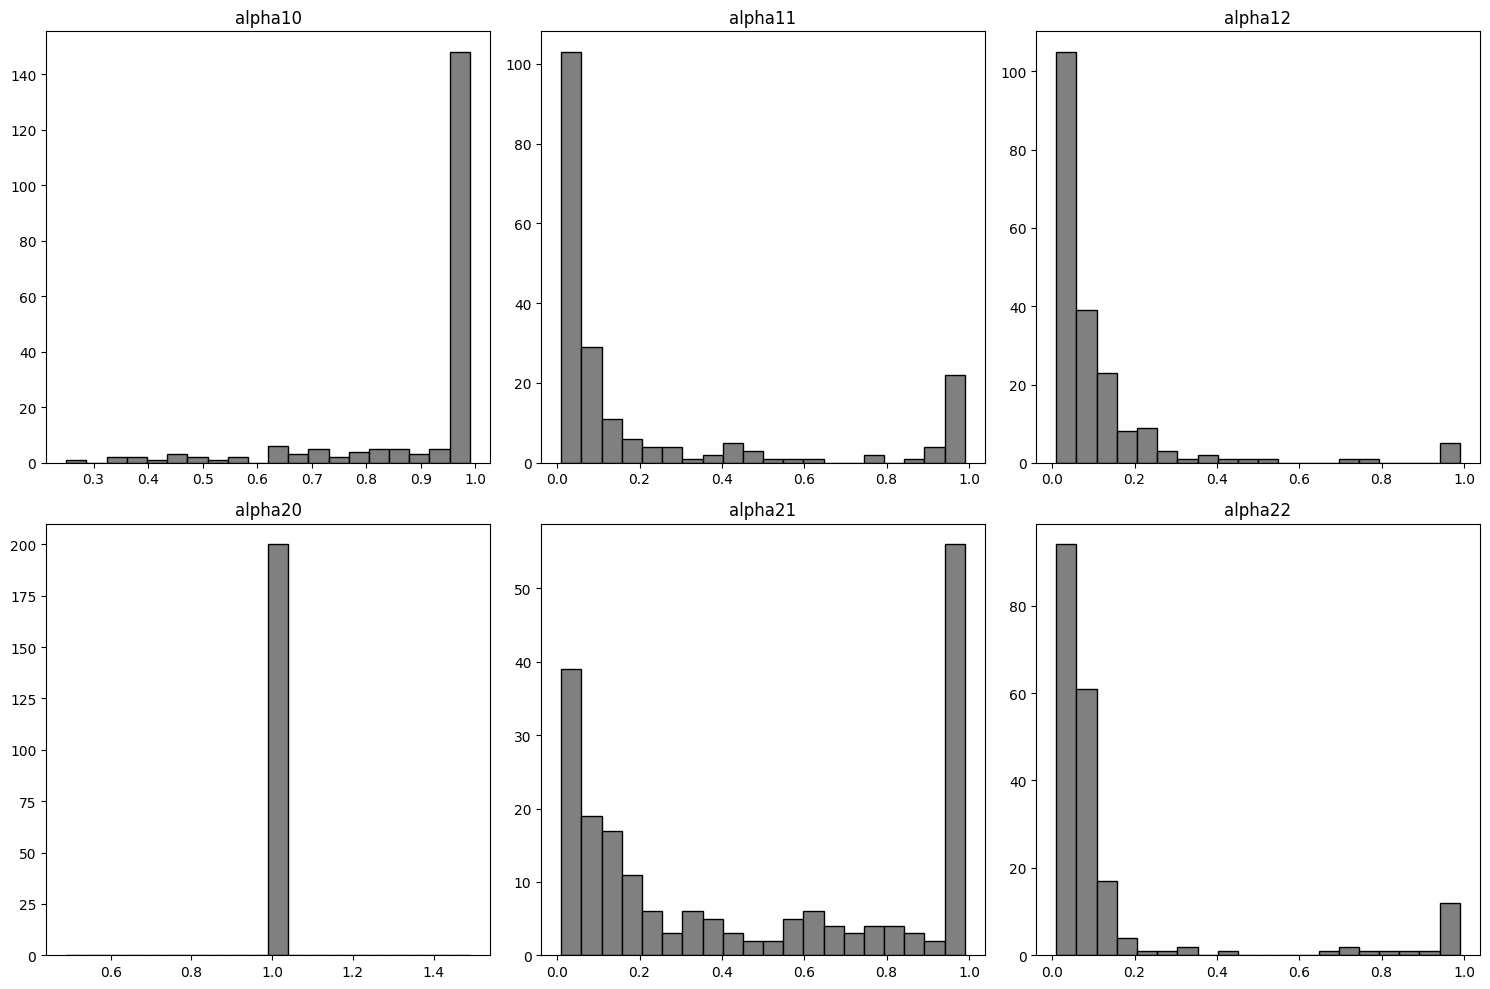

In [10]:
#3.(c)
import matplotlib.pyplot as plt

# 保存参数值以便绘图
alpha10_vals = []
alpha11_vals = []
alpha12_vals = []
alpha20_vals = []
alpha21_vals = []
alpha22_vals = []

# 设置总的迭代次数
iterations = 7000

# 执行 Gibbs 取样，并在最后2000次迭代中保存参数值
for iteration in range(iterations):
    beta1, beta2, alpha10, alpha11, alpha12, alpha20, alpha21, alpha22, e1, e2 = gibbs_sampling(returns, 1)
    if iteration >= iterations - 2000 and iteration % 10 == 0 :  # 只保存最后 2000 次迭代的结果
        alpha10_vals.append(alpha10)
        alpha11_vals.append(alpha11)
        alpha12_vals.append(alpha12)
        alpha20_vals.append(alpha20)
        alpha21_vals.append(alpha21)
        alpha22_vals.append(alpha22)

# 绘制结果
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].hist(alpha10_vals, bins=20, color='grey', edgecolor='black')
axs[0, 0].set_title('alpha10')

axs[0, 1].hist(alpha11_vals, bins=20, color='grey', edgecolor='black')
axs[0, 1].set_title('alpha11')

axs[0, 2].hist(alpha12_vals, bins=20, color='grey', edgecolor='black')
axs[0, 2].set_title('alpha12')

axs[1, 0].hist(alpha20_vals, bins=20, color='grey', edgecolor='black')
axs[1, 0].set_title('alpha20')

axs[1, 1].hist(alpha21_vals, bins=20, color='grey', edgecolor='black')
axs[1, 1].set_title('alpha21')

axs[1, 2].hist(alpha22_vals, bins=20, color='grey', edgecolor='black')
axs[1, 2].set_title('alpha22')

plt.tight_layout()
plt.show()